In [1]:
# オートエンコーダで　潜在空間に落とし込めるので　情報量を圧縮できる
#　前処理でよく使われる　AEとLSTMでCFDの高速化ができる Latent Space physics Towards Learning the temporal Evolution of fluid flow
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.MNIST(root="./data",train=True,download=True,transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 236890540.75it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 87779488.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 85649956.61it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17771015.64it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
train_loader= DataLoader(train_dataset,batch_size=32,shuffle=True)

In [7]:
class ConvAE(nn.Module):
  def __init__(self):
    super().__init__()
    # encoder
    self.en = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),#元サイズが28x28-->14x14になる
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),#7x7になる
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
    )
    # decodor
    self.de = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels=8,out_channels=1,kernel_size=3,padding=1),
        nn.Tanh()

    )
  def forward(self,x):
    x = self.en(x)
    x = self.de(x)
    return x

In [8]:
model = ConvAE()
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [10]:
num_epochs = 15
losses = []
for epoch in range(num_epochs):
  running_loss = 0.0
  for imgs, _ in train_loader:
    imgs = imgs.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output,imgs)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  running_loss /= len(train_loader)
  losses.append(running_loss)
  print(f"epoch:{epoch} loss:{running_loss}")

epoch:0 loss:0.014526236841082573
epoch:1 loss:0.0061838010524710016
epoch:2 loss:0.005215027228867014
epoch:3 loss:0.0047253204027811685
epoch:4 loss:0.004426778710881869
epoch:5 loss:0.004217361822103461
epoch:6 loss:0.004065233446533481
epoch:7 loss:0.0039054962761700153
epoch:8 loss:0.003756213613599539
epoch:9 loss:0.0036570642763127884
epoch:10 loss:0.0035915925775965056
epoch:11 loss:0.00353274132249256
epoch:12 loss:0.003488909897580743
epoch:13 loss:0.0034473831694573163
epoch:14 loss:0.0034112555753439667


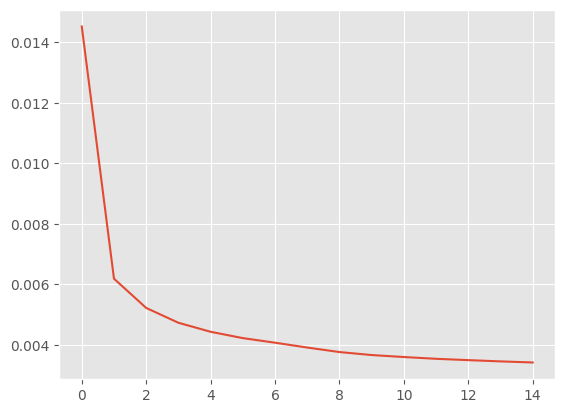

In [11]:
plt.style.use("ggplot")
plt.plot(losses)

In [12]:
data_iter = iter(train_loader)

In [15]:
imgs, _ = next(data_iter)

In [51]:
img = imgs[0]
img_permute = img.permute(1,2,0) # チャネルラスとにする

<Axes: >

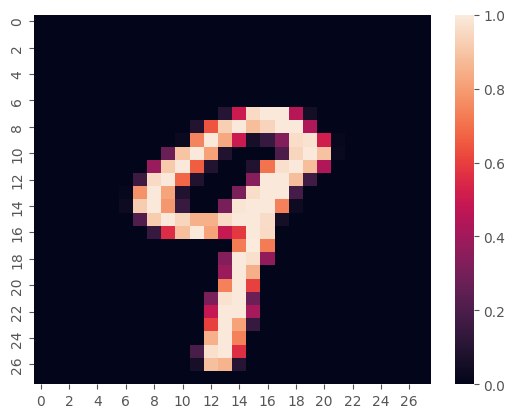

In [52]:
sns.heatmap(img_permute[ : , : , 0])

In [53]:
x_en = model.en(imgs.to(device))

In [54]:
x_en2 = x_en[0].permute(1,2,0)

<Axes: >

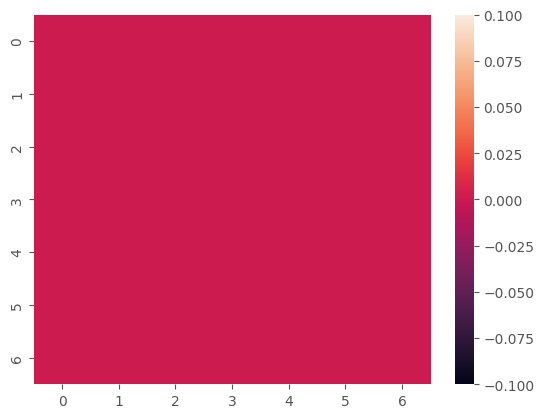

In [55]:
sns.heatmap(x_en2[:, :, 0].detach().to("cpu"))


<Axes: >

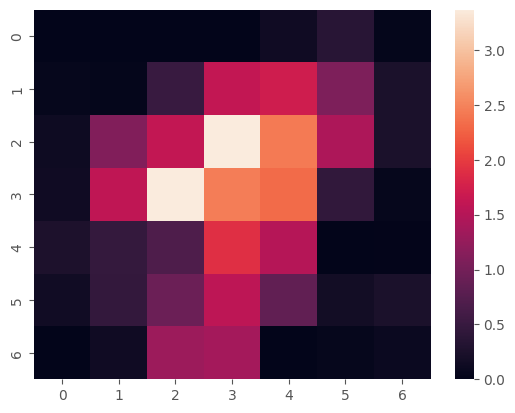

In [56]:
sns.heatmap(x_en2[:, :, 4].detach().to("cpu"))

# detachは勾配計算を切り離し
# device上にあるのでcpuに持ってくること

In [57]:
# encorde decorde
x_ae = model(imgs.to(device))

<Axes: >

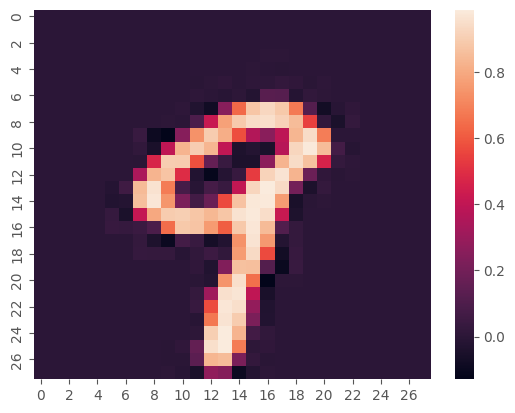

In [58]:
sns.heatmap(x_ae[0].permute(1,2,0).detach().to("cpu")[:,:,0])

In [ ]:
# 上が復元後の情報！